# TODO:
* Test function with 1 variable
* Implementing stepwise regression, ALAMO and symbolic regression (https://doi.org/10.1126/sciadv.aav6971)
* Tutorial problem - propose your own function and benchmark and/or we provide a function for them to benchmark.
* Introduce all methods briefly as well as their implementation

## ALAMO

### Explanation

> ALAMO is a computational methodology for leaning algebraic functions from data. Given a data set, the
approach begins by building a low-complexity, linear model composed of explicit non-linear transformations
of the independent variables. Linear combinations of these non-linear transformations allow a linear model
to better approximate complex behavior observed in real processes.

> The model is refined, as additional data
are obtained in an adaptive fashion through error maximization sampling using derivative-free optimization.
Models built using ALAMO can enforce constraints on the response variables to incorporate first-principles
knowledge.

### Instructions

Get an academic license with your college email from the official ALAMO site.
https://minlp.com/alamo-licenses

The license will be emailed to you as a text file within a few days of the request.
You need to open it with a text editor (Notaped, VSCode, etc...) and copy the contents to the cell bellow.

### Resources

Publication https://arxiv.org/abs/1705.10918

Python's interface to ALAMO: https://pypi.org/project/alamopy/

ALAMO download https://minlp.com/alamo-downloads

Manual
https://idaes-pse.readthedocs.io/en/latest/explanations/modeling_extensions/surrogate/api/alamopy/index.html

In [ ]:
from pathlib import Path

working_dir = Path.cwd()
print(working_dir)

In [ ]:
license = """
COPY YOUR LICENSE HERE (SUBSTITUTE THIS TEXT)
MAKE SURE TO EXECUTE THIS CELL AFTERWARDS
"""

license_file = working_dir / "alamo-linux64" / "alamolice.txt"
with open(license_file, "w") as file:
  file.write(license.lstrip("\n").rstrip("\n"))

Simple example to see if we can generate model for $y = x^2 + z^2 + 1$

In [9]:
import numpy as np
from alamopy.almain import doalamo

In [10]:
xdata = np.random.rand(10, 3)
xdata[:, 0] *= 10  # Make x1 go from 0 to 10
xdata[:, 1] *= 5  # Make x2 go from 0 to 5

zdata = xdata[:, 0] ** 2 + xdata[:, 1] ** 2

In [7]:
opts = doalamo(
    xdata,
    zdata,
    noutput=1,
    keep_alm_file=True,
    keep_lst_file=True,
    print_alm_output=True,
    monomialpower=[2, 3],
    crncustom=1,
    zlabels=["z"],
    customcon=["1 -z"],
)

b''
 ***************************************************************************
 ALAMO version 2022.10.7. Built: LNX-64 Fri Oct 7 21:05:57 EDT 2022 

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Ilya Sandoval at Imperial College London, os220@ic.ac.uk.
 ***************************************************************************
 
 ALAMO terminated with termination code 1 
 ALAMO must be called with one or two command line arguments.
 ***************************************************************************

You may view the output files in /tmp/io-ysc_7lkz


## Symbolic Regression - Genetic Programming

### Explanation

> Symbolic regression is the most generalisable method, as a design matrix does not need to be constructed (i.e.: the matrix of non-linear transformations of state variables that a modeller believes could be present in a given surrogate model). Instead, in this framework, building blocks are specified which define a feasible mathematical expression space. These building blocks can be state variables (e.g.: $C_A$, $C_B$, $T$), mathematical operators (e.g.: '+', '-', 'cos', 'sin'), or user-defined analytical functions (e.g.: $\frac{1}{k_1C_A+k_2C_B}$). 

> Many algorithms have been used to implement symbolic regression, such as genetic programming, compressed-sensing, Bayesian optimisation or deep learning. Here, the focus will be on symbolic regression implemented with genetic programming (SR-GP), as this is the most widely used approach for symbolic regression. 

> An important distinction should be made between genetic programming and genetic algorithm: GP is a special case od GA where the candidate solutions of an optimisation problem are programs (i.e.: functions/equations) instead of coordinate values. As such, the concept of GP is analgous to GA, where solutions are evolved based on Darwin's theory of evolution: survival of the fittest. 

> For the SR framework, this concept is translated as follows: an initial population of $\textit{m}$ models is generated and their fitness is computed (here, the fitness refers to the error between the prediction from the model generated and our data); $\textit{n}$ number of models are selected and $\textit{m}-\textit{n}$ models are killed (i.e.: these models will no longer be
considered); the $\textit{n}$ selected models are allowed to crossover and produce $\textit{m}-\textit{n}$ offspring (this is important to maintain the size of the population constant throughout generations, so our population does not explode or vanish); with a given probability $\textit{p}$ the $\textit{m}-\textit{n}$ offspring models are mutated (here, mutated refers to a given mathematical building block of the model to be changed randomly with some
probability $\textit{p}$); the fitness of the offspring models are computed and the process is iterated until convergence or a termination criterion is achieved. A pseudocode of GP is provided below for clarity, along with a figure to graphically illustrate the concepts of crossover and mutation in the SR framework.

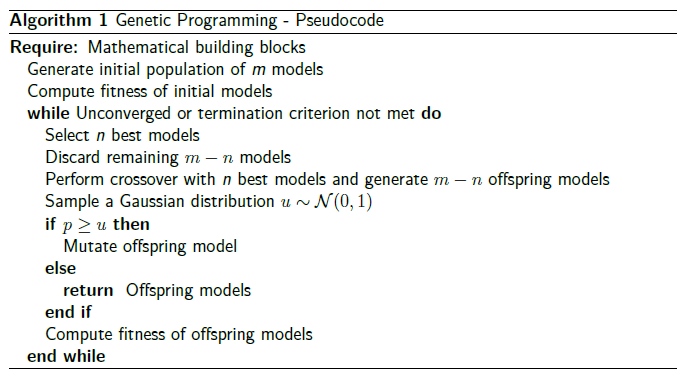

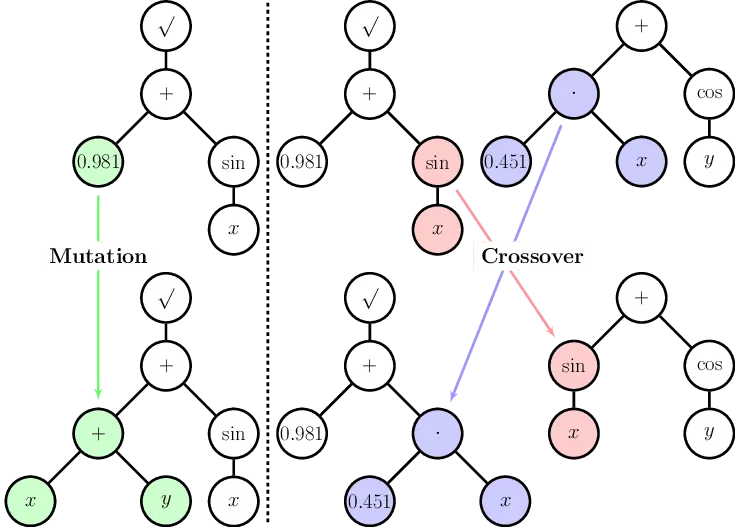

### Example

> Now, we will demonstrate how to use an existing implementation of SR-GP by Miles Cranmer (for those interested, the GitHub repository can be found [here](https://https://github.com/MilesCranmer/PySR)). The first step will be to install and import all necessary packages, as well as generating some data for us to benchmark the framework. For this particular example, a simple one-dimensional function will be used:

$f(x)=sin(x) + sin(\frac{10x}{3})$

In [ ]:
#Importing all necessary python packages#
import numpy as np
import matplotlib.pyplot as plt
from pysr import PySRRegressor
np.random.seed(1998)

In [ ]:
#Generating data#
def func_1(x):
  return np.sin(x)+np.sin(10*x/3)

lower_bound = -6
upper_bound = 6
number_datapoints = 2000
x = np.linspace(lower_bound,upper_bound,number_datapoints)
y = func_1(x)
observed_y = y + np.random.normal(0,0.1,number_datapoints)

In [ ]:
#Plotting data#
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, y, label='True Function', color='r', linewidth=3, alpha=0.6)
ax.scatter(x, observed_y, color='b', s=3, label='Observed Datapoints')
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(alpha=0.5)
ax.legend(loc=1)
plt.show()

> Once we have generated and plotted our data, the next step, as per the explanation provided, is to choose which building blocks we will be using to construct our surrogate model.
> As we can see from the generated plot, our underlying function has some sinusoidal behaviour, and therefore, we should probably include 'sin' as a building block. We will not be including any other trignometric functions because: they can be expressed as a function of 'sin' (remember trignometric identities?) and it is better to start with a limited number of building blocks (to limit the search space - computational reason) and increase it if need be. We will also compliment 'sin' with very common operators such as '+', '-', '*', '/'. 

In [ ]:
#Running PySR - this might take some time, be patient#
x = x.reshape(-1, 1)
observed_y = observed_y.reshape(-1, 1)
file_name = str('hall_of_fame_'+'func_1'+'.csv')
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*", "/", "-"],
    unary_operators=["sin"],
    model_selection="accuracy",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
    maxsize = 20,
    timeout_in_seconds = 300,
    parsimony = 1e-5,
    equation_file= file_name,
)

model.fit(x,observed_y)